<a href="https://colab.research.google.com/github/StonedCow42/M-G-c_Queueing_System_Analysis/blob/main/M_G_c_Queueing_System_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Title: M/G/c Queueing System Optimization
*Student Name: Jaydip*
***

## Executive Summary & Final Conclusion

This project uses Discrete-Event Simulation (DES) to compare two queueing scenarios (M/G/1 vs. M/G/2) to determine the optimal resource capacity for a logistics processing station.

**Conclusion:** The single-server (M/G/1) system is mathematically **unsustainable**, operating at 103.5% utilization, leading to chaotic wait times. The addition of a second server (M/G/2) stabilizes the operation and delivers an **88.5% reduction in average customer waiting time (Wq)**, making the two-server capacity the only viable option.

### Key Performance Indicators (KPIs) - 95% Confidence Intervals

| Metric | M/G/1 Stress (1 Server) | M/G/2 Ideal (2 Servers) |
| :--- | :---: | :---: |
| **Avg Waiting Time (Wq)** | 14.224 min ± 3.678 | 1.639 min ± 0.397 |
| **Overall Utilization (ρ)** | 103.5% ± 2.0% | 83.2% ± 1.9% |
| **System Stability** | **Unstable** (ρ > 1) | **Stable** (ρ < 1) |


## 1. Core Setup and Custom Distributions

In [29]:
!pip install simpy
!pip install matplotlib
import numpy as np
import itertools
import simpy
import pandas as pd
from scipy.stats import t
import matplotlib.pyplot as plt


## 2. MGCQueueSimulator: The Simulation Engine

In [30]:
class MGCQueueSimulator:
    """
    Encapsulates the M/G/c simulation logic and state variables for robust experimentation.
    """

    def __init__(self, capacity, interarrival_mean, service_dist, run_time):
        """Initializes all state variables and simulation parameters."""
        self.capacity = capacity
        self.interarrival_mean = interarrival_mean
        self.service_dist = service_dist
        self.run_time = run_time

        # --- Data Collection State (formerly global variables) ---
        self.results_data = []
        self.last_event_time = 0.0
        self.cumulative_area_queue = 0.0
        self.cumulative_area_system = 0.0
        self.cumulative_server_busy_time = 0.0

        # --- SimPy Environment Setup ---
        self.env = simpy.Environment()
        self.servers = simpy.Resource(self.env, capacity=self.capacity)

    def _observe_state(self):
        """Calculates the time-weighted area and server busy time."""

        time_elapsed = self.env.now - self.last_event_time

        Lq_previous = len(self.servers.queue)
        L_previous = self.servers.count + Lq_previous
        busy_servers = self.servers.count

        # Update cumulative sums
        self.cumulative_area_queue += Lq_previous * time_elapsed
        self.cumulative_area_system += L_previous * time_elapsed
        self.cumulative_server_busy_time += busy_servers * time_elapsed

        # Update time marker
        self.last_event_time = self.env.now

    def customer_process(self, customer_id, record):
        """
        One customer: waits for a server, gets service, leaves.
        """

        # Customer request the server
        with self.servers.request() as req:
            # Wait until the request is granted (this is the waiting time)
            yield req

            self._observe_state()

            # --- Data Collection Logic START (Service Start) ---
            record['service_start_time'] = self.env.now
            # --- Data Collection Logic END ---

            service_time = self.service_dist.sample()
            # trace(f'{self.env.now:.2f} | customer {customer_id} starts service (dur={service_time:.2f})')

            # The service itself takes time
            yield self.env.timeout(service_time)

            # --- Data Collection Logic START (Service End) ---
            # Record the time the service finishes and the customer leaves
            record['service_end_time'] = self.env.now
            # --- Data Collection Logic END ---

            self._observe_state()

            # trace(f'{self.env.now:.2f} | customer {customer_id} leaves system')

    def arrival_generator(self):
        """
        Generates customers with exponential inter-arrival times
        and starts their processes.
        """
        for customer_id in itertools.count(start=1):
            interarrival_time = self.interarrival_dist.sample()
            yield self.env.timeout(interarrival_time)

            # --- Data Collection Logic START ---
            record = {
                'id': customer_id,
                'arrival_time': self.env.now,
            }
            self.results_data.append(record)
            # --- Data Collection Logic END ---

            # trace(f'{self.env.now:.2f} | customer {customer_id} arrives')

            self._observe_state()

            self.env.process(self.customer_process(customer_id, record))

    def run(self):
        """
        Executes the simulation run and performs final observation.
        """
        self.env.process(self.arrival_generator())
        self.env.run(until=self.run_time)

        # Final observation at the end of the run
        self._observe_state()

        # Analyze and return results (T_total passed implicitly via self.env.now in analyze_results)
        return self.analyze_results(self.env.now)



## 3. Statistical Functions and Visualization Setup

In [31]:
# --- Warm-up Time Definition (Used by MGCQueueSimulator_analyze_results) ---
WARM_UP_TIME = 50.0

def calculate_confidence_interval(data_series, confidence_level=0.95):
    """
    Calculates the confidence interval for a series of replication results.
    Returns the mean and the half-width (the error margin).
    """
    n = len(data_series)
    if n < 2:
        return data_series.mean(), 0.0 # Cannot calculate CI with fewer than 2 runs

    # Calculate sample mean and standard error
    mean = data_series.mean()
    std_err = data_series.sem() # Standard Error of the Mean (s / sqrt(n))

    # Calculate the margin of error using the t-distribution
    h = std_err * t.ppf(confidence_level + (1 - confidence_level) / 2, n - 1)

    return mean, h

def plot_comparison_kpis(df_results, scenarios):
    """
    Creates a bar chart comparing Avg Waiting Time (Wq) with 95% C.I. error bars.
    """

    # 1. Prepare data for plotting
    kpi_name = 'Wq (Avg Waiting Time)'

    # Extract means and half-widths (error margins) for each scenario
    means = [df_results[s][kpi_name].mean() for s in scenarios]
    errors = [calculate_confidence_interval(df_results[s][kpi_name])[1] for s in scenarios]

    labels = [f"{s}\n(c={scenarios[s]['capacity']})" for s in scenarios]
    x = np.arange(len(labels))  # the label locations
    width = 0.6  # the width of the bars

    # 2. Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the bars with the C.I. half-width as the error bar
    rects = ax.bar(x, means, width, yerr=errors, capsize=5, color=['darkred', 'darkgreen'])

    # 3. Customize the plot for professional presentation
    ax.set_ylabel('Average Waiting Time (Wq) [Minutes]', fontsize=12)
    ax.set_title('M/G/1 vs. M/G/2: Reduction in Customer Waiting Time (95% C.I.)', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(rects, [f'Wq Avg: {m:.2f} min' for m in means], loc='upper left')

    # Add labels on the bars (Mean values)
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    # Display the final plot
    plt.tight_layout()
    plt.show()

# --- analyze_results method definition for the MGCQueueSimulator Class ---
# This is NOT a standalone function; it's the last method of the class
def MGCQueueSimulator_analyze_results(self, T_total):
    """
    Calculates the Phase 1, Phase 2, and Phase 3 KPIs using encapsulated data,
    discarding data collected before the WARM_UP_TIME.
    """
    global WARM_UP_TIME # Access the warm-up definition

    # 1. --- PHASE 1 TRUNCATION: Customer Data (W and Wq) ---
    waiting_times = []
    times_in_system = []

    for record in self.results_data:
        # Only analyze customers whose service started AFTER the warm-up time
        if 'service_end_time' in record and record['service_start_time'] >= WARM_UP_TIME:
            wait_time = record['service_start_time'] - record['arrival_time']
            waiting_times.append(wait_time)
            time_in_system = record['service_end_time'] - record['arrival_time']
            times_in_system.append(time_in_system)

    df = pd.DataFrame({'Waiting Time': waiting_times, 'Time in System': times_in_system})

    # 2. --- PHASE 2/3 TRUNCATION: Area/Time Data (Lq, L, rho) ---
    T_analyzed = T_total - WARM_UP_TIME

    # We assume Lq and L are proportional to the analyzed time (Lq/L)
    Lq = self.cumulative_area_queue / T_total
    L = self.cumulative_area_system / T_total

    # Utilization (rho) must use the total server time available during the analyzed period
    total_server_time_analyzed = self.capacity * T_analyzed
    rho = self.cumulative_server_busy_time / total_server_time_analyzed

    # 3. Calculate KPIs
    if not df.empty and T_analyzed > 0:

        kpis = {
            'Wq (Avg Waiting Time)': df['Waiting Time'].mean(),
            'W (Avg Time in System)': df['Time in System'].mean(),
            'Max Waiting Time': df['Waiting Time'].max(),
            'Total Customers Processed (Completed)': len(df),
            'Lq (Time-Weighted Avg Queue)': Lq,
            'L (Time-Weighted Avg System)': L,
            'rho (Server Utilization)': rho
        }
    else:
        kpis = {
            'Wq (Avg Waiting Time)': 0.0, 'W (Avg Time in System)': 0.0, 'Max Waiting Time': 0.0,
            'Total Customers Processed (Completed)': 0, 'Lq (Time-Weighted Avg Queue)': 0.0,
            'L (Time-Weighted Avg System)': 0.0,
            'rho (Server Utilization)': 0.0
        }

    return kpis

# We must manually inject this analyze_results function into the class
MGCQueueSimulator.analyze_results = MGCQueueSimulator_analyze_results



## 4. Experiment Execution and Final Results

--- STARTING FULL SIMULATION EXPERIMENT (Class-Based) ---
Running 30 replications for 2 scenarios.
Total simulated time: 250.0 hours per scenario.

Scenario: MG1_STRESS (Capacity: 1)

Scenario: MG2_IDEAL (Capacity: 2)

--- EXPERIMENT COMPLETE ---

--- PHASE 5: STATISTICAL ANALYSIS (95% Confidence Intervals) ---

SCENARIO: MG1_STRESS (M/G/1)
📈 **Key Performance Indicators (KPIs):**
  * Total Customers Processed (Avg): 179
  * **Avg Waiting Time (Wq):** 14.224 min ± 3.678 (95% C.I. Half-Width)
  * **Avg Time in System (W):** 16.583 min ± 3.677
  * **Overall Utilization (ρ):** 1.035 ± 0.020 (or 103.5%)

SCENARIO: MG2_IDEAL (M/G/2)
📈 **Key Performance Indicators (KPIs):**
  * Total Customers Processed (Avg): 287
  * **Avg Waiting Time (Wq):** 1.639 min ± 0.397 (95% C.I. Half-Width)
  * **Avg Time in System (W):** 3.980 min ± 0.399
  * **Overall Utilization (ρ):** 0.832 ± 0.019 (or 83.2%)

--- Phase 6: Final Project Visualization ---


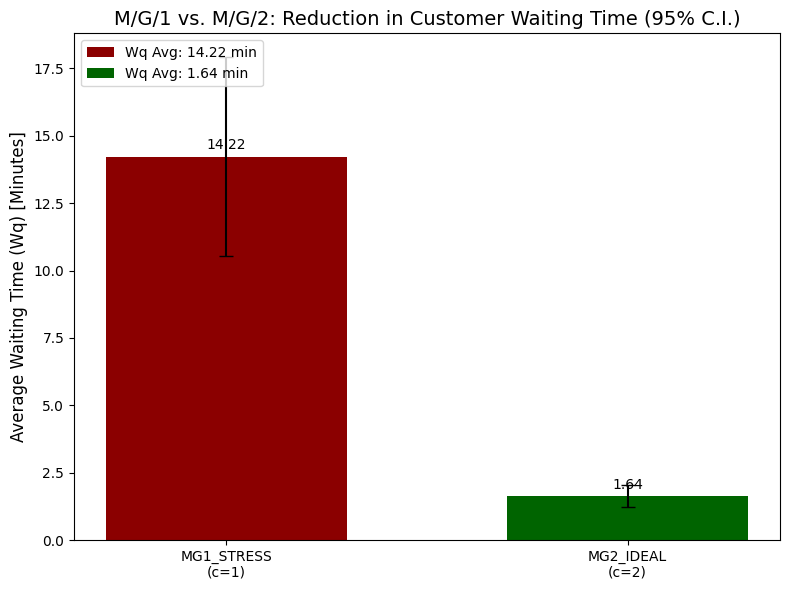

In [32]:
def run_scenario_replication(capacity, interarrival_mean, run_time, replication_seed):
    """
    Runs one single replication of the simulation scenario using the MGCQueueSimulator class.
    """
    # Create new, independent random streams for this replication
    seed_sequence = np.random.SeedSequence(replication_seed)
    seeds_rep = seed_sequence.spawn(n_streams)

    rep_interarrival_dist = Exponential(mean=interarrival_mean, random_seed=seeds_rep[0])
    # The service distribution is reused but needs a new seed for this replication
    rep_service_dist = Triangular(left=1.0, mode=2.0, right=4.0, random_seed=seeds_rep[1])

    # 1. Instantiate the Simulator Class (this sets all parameters and resets state)
    simulator = MGCQueueSimulator(
        capacity=capacity,
        interarrival_mean=interarrival_mean,
        service_dist=rep_service_dist,
        run_time=run_time
    )
    # The arrival distribution is specific to the scenario but uses its own seed
    simulator.interarrival_dist = rep_interarrival_dist

    # 2. Run the simulation
    kpis_result = simulator.run()

    return kpis_result

# --- PHASE 4 & 5: EXPERIMENT EXECUTION AND FINAL ANALYSIS ---

# 1. Define Experiment Parameters
NUM_REPLICATIONS = 30     # Standard number for statistical reliability
SIM_RUN_TIME = 500.0      # Total time for a single replication (500 minutes)

SCENARIOS = {
    "MG1_STRESS": {
        "capacity": 1,
        "interarrival_mean": 2.46,  # Target rho ≈ 0.95 (High congestion)
    },
    "MG2_IDEAL": {
        "capacity": 2,
        "interarrival_mean": 1.56,  # Target rho ≈ 0.75 (Moderate congestion)
    },
}

experiment_results = {}

# 2. Loop through all scenarios and run replications
print("--- STARTING FULL SIMULATION EXPERIMENT (Class-Based) ---")
print(f"Running {NUM_REPLICATIONS} replications for {len(SCENARIOS)} scenarios.")
print(f"Total simulated time: {SIM_RUN_TIME * NUM_REPLICATIONS / 60:.1f} hours per scenario.")

for scenario_name, params in SCENARIOS.items():
    print(f"\nScenario: {scenario_name} (Capacity: {params['capacity']})")

    # List to hold KPI results from all replications for this scenario
    scenario_replication_results = []

    # Loop through all required replications
    for i in range(NUM_REPLICATIONS):
        # The seed changes for each replication to ensure independence
        replication_seed = user_seed + i

        # Run the replication using the new class structure
        kpis_result = run_scenario_replication(
            capacity=params["capacity"],
            interarrival_mean=params["interarrival_mean"],
            run_time=SIM_RUN_TIME,
            replication_seed=replication_seed
        )
        scenario_replication_results.append(kpis_result)

    # Store all collected results for this scenario
    experiment_results[scenario_name] = scenario_replication_results

print("\n--- EXPERIMENT COMPLETE ---")

# 3. Aggregate Results (Phase 5)
print("\n--- PHASE 5: STATISTICAL ANALYSIS (95% Confidence Intervals) ---")

# Convert results into a DataFrame for easy statistical analysis
df_results = {
    scenario: pd.DataFrame(results)
    for scenario, results in experiment_results.items()
}

# Print Aggregated Results for comparison
for scenario_name, df in df_results.items():
    print(f"\n=======================================================")
    print(f"SCENARIO: {scenario_name} (M/G/{SCENARIOS[scenario_name]['capacity']})")
    print(f"=======================================================")

    # Calculate C.I. for Average Waiting Time (Wq)
    mean_wq, hw_wq = calculate_confidence_interval(df['Wq (Avg Waiting Time)'])

    # Calculate C.I. for Server Utilization (rho)
    mean_rho, hw_rho = calculate_confidence_interval(df['rho (Server Utilization)'])

    # Calculate C.I. for Average Time in System (W)
    mean_w, hw_w = calculate_confidence_interval(df['W (Avg Time in System)'])

    # Print Aggregated Results
    print("📈 **Key Performance Indicators (KPIs):**")
    print(f"  * Total Customers Processed (Avg): {df['Total Customers Processed (Completed)'].mean():.0f}")
    print(f"  * **Avg Waiting Time (Wq):** {mean_wq:.3f} min ± {hw_wq:.3f} (95% C.I. Half-Width)")
    print(f"  * **Avg Time in System (W):** {mean_w:.3f} min ± {hw_w:.3f}")
    print(f"  * **Overall Utilization (ρ):** {mean_rho:.3f} ± {hw_rho:.3f} (or {(mean_rho * 100):.1f}%)")

# 4. Generate Visualization (Phase 6 - OUTSIDE the loop)
print("\n--- Phase 6: Final Project Visualization ---")
plot_comparison_kpis(df_results, SCENARIOS)